# Forecasting

In [11]:
from feature_generation import *

import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
means = df.groupby("HistoryDate").mean()[targets]
means = means[:-135]
means = clean_data(means)
feature_set = get_feature_sets(means, targets)

## Calculating Error

Common way of calculating error in timeseries forecasting is [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [13]:
def mape_error(y_actual, y_pred, mean=True):
    result = 100 * ((y_actual - y_pred).abs() / y_actual)
    if mean:
        return result.mean()
    else:
        return result

## Base Error

To evaluate our models and see if they are useful, we need a base error to compare them with. One way of doing this is to use shifted data as predictions.

In [14]:
# input:            pandas dataframe representing the target variables, size of the window (must be higher than the highest value in averages parameter)
# input example:    average=[[7,14], [7,14,21]] calculate the averages of t-7 and t-14, then find MAPE with this average. Same for t-7, t-14 and t-21
def get_shifted_errors(y, size, average=[]):
    shifted_errors = pd.DataFrame(dtype='float64')
    for target in y.columns:
        windows = get_windows(y[target], size, drop_t=False)
        column_name = "%s_Error" % target
        for column in windows.columns[1:]:
            shifted_errors.loc[column, column_name] = mape_error(windows['t'], windows[column])

        for offsets in average:
            offsets = [str(offset) for offset in offsets]
            shifted_errors.loc['t-(%s)'%','.join(offsets), column_name] = mape_error(windows['t'], windows[['t-%s'%offset for offset in offsets]].mean(axis=1))
    
    return shifted_errors 

In [15]:
shifted_errors = get_shifted_errors(means[['CashOut', 'CashIn']], 40, average=[[7,14], [7,14,21]]).sort_values(by='CashOut_Error')

In [16]:
shifted_errors.sort_values(by='CashIn_Error')[:3]

,CashOut_Error,CashIn_Error
"t-(7,14,21)",27.679029,12.537702
"t-(7,14)",29.824265,13.473626
t-21,33.087798,14.641079


In [17]:
shifted_errors.sort_values(by='CashOut_Error')[:3]

,CashOut_Error,CashIn_Error
t-28,22.597897,14.661005
t-35,25.308170,15.114787
"t-(7,14,21)",27.679029,12.537702


### Base errors:

Averages of t-7, t-14 and t-21 performed best for CashIn while t-28 was best for CashOut

* CashIn: 12.47
* CashOut: 22.59

## Forecasting

### Models to try:
* Random forest
* Lightgbm
* Catboost

## Random Forest

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [37]:
target = 'CashOut'

X = feature_set[feature_set.columns[2:]]
y = feature_set[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print("Predicting: %s" % target)

Predicting: CashOut


In [38]:
from forecasting import *

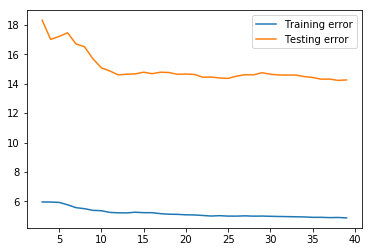

Best test error: 14.226 with 38 trees.


In [39]:
compare_model_parameter(RandomForestRegressor, X, y, 'n_estimators', list(range(3,40)), shuffle=False)

In [51]:
forest = RandomForestRegressor(n_estimators=38, random_state=5)
forest.fit(X_train, y_train)
print("Training error: %.4f" % mape_error(y_train, forest.predict(X_train)))
print("Testing error:  %.4f" % mape_error(y_test, forest.predict(X_test)))

Training error: 4.8992
Testing error:  14.2256


In [52]:
draw_model_error(forest, X, y, split_from=X_train.index[-1])

## LGBM

In [42]:
import optuna
from lightgbm import LGBMRegressor

In [43]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, shuffle=False, test_size=0.2)
    param = {
        'metric': 'mape', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mape_error(test_y, preds)
    
    return rmse

In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-06 15:36:58,393] A new study created in memory with name: no-name-88c241a1-dbca-4737-bcd9-82a25006d9f8
[I 2021-07-06 15:36:59,298] Trial 0 finished with value: 12.847655727243426 and parameters: {'reg_alpha': 0.13934122211763625, 'reg_lambda': 0.04626187208234796, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 945, 'min_child_samples': 247, 'min_data_per_groups': 39}. Best is trial 0 with value: 12.847655727243426.
[I 2021-07-06 15:37:00,179] Trial 1 finished with value: 12.698950890870355 and parameters: {'reg_alpha': 0.140552640775067, 'reg_lambda': 3.0468863092927836, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 797, 'min_child_samples': 112, 'min_data_per_groups': 88}. Best is trial 1 with value: 12.698950890870355.
[I 2021-07-06 15:37:01,262] Trial 2 finished with value: 12.839951379225303 and parameters: {'reg_alpha': 0.0010898743699377606, 'reg_lambda': 1.0589315352

Number of finished trials: 10
Best trial: {'reg_alpha': 0.002251314604253428, 'reg_lambda': 0.008234177662096873, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 984, 'min_child_samples': 56, 'min_data_per_groups': 59}
Best value: 11.82900154401845


In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
#params=study.best_params   
params = {'reg_alpha': 1.483192630608853, 'reg_lambda': 0.36626510385236044, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 348, 'min_child_samples': 6, 'min_data_per_groups': 91}
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mape'
params['cat_smooth'] = params.pop('min_data_per_groups')

In [47]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 10, shuffle=False)

predictions = np.zeros(len(X_test))

for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_tra, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_tra, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    model = LGBMRegressor(**params)
   
    model.fit(X_tra, y_tra, eval_set = [(X_val, y_val)], eval_metric = 'mape', verbose = False, early_stopping_rounds = 222)
    
    predictions += model.predict(X_test) / folds.n_splits 

In [48]:
from forecasting import *

In [49]:
weekly_errors = get_error_with_freq(y_test, predictions, 'w')
draw_error_over_time(y_test, predictions, weekly_errors, X_train.index[-1])

In [50]:
"Test error of LGBM is %.3f." % mape_error(y_test, predictions)

'Test error of LGBM is 13.185.'